# Главная модель

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import numpy as np
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report
%matplotlib inline

### Загрузим наши предобработанные данные

In [15]:
tourney_hand_summary = pd.read_csv('input\\tourney_hand_summary_03_18_18.csv')

In [16]:
tourney_hand_summary['UTG_act_p_1']  = tourney_hand_summary['UTG_act_p'].apply(lambda x: str(x)[:1])
data_UTG = tourney_hand_summary[tourney_hand_summary.UTG_act_p_1=='R']
data_UTG = data_UTG[['UTG_card', 'UTG_amt_b_p', 'UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb',
                     'MP_2_bb', 'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'UTG_amt_exp']]
data_UTG['profit'] = np.where(data_UTG.UTG_amt_exp > 0, 1, 0)
del data_UTG['UTG_amt_exp']

In [17]:
X = data_UTG.copy()
y = data_UTG['profit']
del X['profit']

### Расширяем количество признаков
#### Добавим пот-оддсы (шансы к банку) 
Это отношение ставки, которую необходимо сравнять, чтобы зайти в игру к общему банку.
Пример, игрок сделал рейз 6 долларов, итого в банке: 6 долларов ставка + 1 доллар малый блайнд + 2 доллара большой = 9 долларов. Игроку на позиции большого блайнда необходимо добавить 6-2=4 доллара (так как он уже 1 доллар внес).
Итак, пот-оддсы равны = 4/9 = 0.44.

Не трудно заметить, что если ставка очень мала, то пот-оддсы падают, это значит, что можно чаще колировать (поддерживать) ставку игрока. То есть в нашем примере, если бы игрок сделал рейз не 6 долларов, а 4. Тогда пот-оддсы = (4-2)/(4+1+2+2) = 0.22.

В турнирной игре влияние становится еще больше, так как размер банка уже большой на префлопе из-за анте(ставки собираются с каждого игрока до любых действий на префлопе). Соответственно игроки чаще заходят в игру, так как это становится выгодно.

In [18]:
def calculate_pot_odds(bets, pos='other'):
    """Calculate pot-odds
    ----------
    bets : list
        bets[0] - amount raise
        bets[1] - amount stack call
    pos : 'other', 'SB' or 'BB'    
        postion call
    """
    if pos == 'BB':
        amt_call = 1
    elif pos == 'SB':
        amt_call = 0.5
    else:
        amt_call = 0
        
    if bets[0] > bets[1]:
        pot_odds = (bets[1] - amt_call) / (bets[1] + bets[1] + 2 - amt_call) 
    else:
        pot_odds = (bets[0] - amt_call) / (bets[0] + bets[0] + 2 - amt_call)          
    return pot_odds

In [19]:
name_stacks = ['UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb', 
               'MP_2_bb', 'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb']

Рассчитаем пот-оддсы для каждого игрока

In [20]:
for name in name_stacks:
    X[name + '_odds'] = X[['UTG_amt_b_p', name]].apply(calculate_pot_odds, axis=1)

#### Переведем в категориальные признаки размеры стеков
Так как у нас есть стеки игроков в больших блайндах, попробуем перевести их в категориальные. 
Например, чем меньше стек, то игрок после рейз может вести себя по разному в зависимости от категории своего стека.

In [21]:
groups = [0, 2, 5, 8, 10, 15, 1000]

In [22]:
for name in name_stacks:
    for k in range(len(groups)-1):
        X[name + '_' + str(groups[k+1])] = \
        np.where(((X[name]>=groups[k]) & (X[name] <groups[k+1])), 1, 0)
    del X[name]

In [23]:
del X['UTG_bb_odds']

In [24]:
X.head()

,UTG_card,UTG_amt_b_p,UTG_1_bb_odds,MP_bb_odds,MP_1_bb_odds,MP_2_bb_odds,CO_bb_odds,BUTTON_bb_odds,SB_bb_odds,BB_bb_odds,...,SB_bb_8,SB_bb_10,SB_bb_15,SB_bb_1000,BB_bb_2,BB_bb_5,BB_bb_8,BB_bb_10,BB_bb_15,BB_bb_1000
5,A7o,12.0,0.0,0.000000,0.0,0.0,0.461538,0.461538,0.461089,0.461538,...,0,0,1,0,0,0,0,0,0,1
17,0,19.0,0.0,0.475000,0.0,0.0,0.443246,0.475000,0.474438,0.440120,...,0,0,0,1,0,0,1,0,0,0
31,0,6.0,0.0,0.428571,0.0,0.0,0.428571,0.428571,0.428571,0.428571,...,0,0,0,1,0,0,0,0,0,1
34,0,2.0,0.0,0.000000,0.0,0.0,0.333333,0.333333,0.333333,0.333333,...,0,0,0,1,0,0,0,0,0,1
42,KJo,8.0,0.0,0.444444,0.0,0.0,0.444444,0.444444,0.444444,0.444444,...,0,0,0,1,0,0,0,0,1,0


### Расширили количество признаков, теперь попробуем нашу базовую модель.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostClassifier(iterations=500, depth=5, learning_rate=0.03, loss_function='Logloss')
model.fit(X_train, y_train, cat_features=[0], verbose=False)

In [29]:
preds_class = model.predict(X_test)
print(classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.63      0.47      0.54      1543
          1       0.69      0.81      0.75      2256

avg / total       0.66      0.67      0.66      3799



#### Попробуем другие группы разбиения стеков на категории

In [30]:
groups = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 1000]

In [31]:
X = data_UTG.copy()
y = data_UTG['profit']
del X['profit']

In [32]:
for name in name_stacks:
    X[name + '_odds'] = X[['UTG_amt_b_p', name]].apply(calculate_pot_odds, axis=1)

In [33]:
for name in name_stacks:
    for k in range(len(groups)-1):
        X[name + '_' + str(groups[k+1])] = \
        np.where(((X[name]>=groups[k]) & (X[name] <groups[k+1])), 1, 0)
    del X[name]

In [34]:
del X['UTG_bb_odds']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = CatBoostClassifier(iterations=500, depth=5, learning_rate=0.03, loss_function='Logloss')
model.fit(X_train, y_train, cat_features=[0], verbose=False)

In [36]:
preds_class = model.predict(X_test)
print(classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.63      0.48      0.54      1543
          1       0.69      0.81      0.74      2256

avg / total       0.67      0.67      0.66      3799



Качество не выросло, а даже слегка упало, оставим старые группы.

### Подберем оптимальные параметры для нашей модели

In [37]:
X = data_UTG.copy()
y = data_UTG['profit']
del X['profit']

In [38]:
groups = [0, 2, 5, 8, 10, 15, 1000]

In [39]:
for name in name_stacks:
    X[name + '_odds'] = X[['UTG_amt_b_p', name]].apply(calculate_pot_odds, axis=1)
    
for name in name_stacks:
    for k in range(len(groups)-1):
        X[name + '_' + str(groups[k+1])] = \
        np.where(((X[name]>=groups[k]) & (X[name] <groups[k+1])), 1, 0)
    del X[name]

In [40]:
del X['UTG_bb_odds'] #удалили колонку, которая уже категоризована

#### Выберем оптимальное количество iterations

In [41]:
param_grid = {
    'iterations': [500, 200, 1000, 2000], 
    'learning_rate': [0.03],
    'depth': [6],
    'l2_leaf_reg': [3],
    'border_count': [32]
}

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [43]:
from sklearn.model_selection import GridSearchCV

model = CatBoostClassifier(loss_function='Logloss', logging_level='Silent')

model = GridSearchCV(model, param_grid)
model.fit(X_train, y_train, cat_features=[0], verbose=False)

GridSearchCV(cv=None, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x000002A600FDB828>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'border_count': [32], 'learning_rate': [0.03], 'l2_leaf_reg': [3], 'depth': [6], 'iterations': [500, 200, 1000, 2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [44]:
model.best_params_

{'border_count': 32,
 'depth': 6,
 'iterations': 500,
 'l2_leaf_reg': 3,
 'learning_rate': 0.03}

Оптимальное количество = 1000.

In [45]:
model.best_score_

0.6659440039643211

In [46]:
best_params = model.best_estimator_.get_params()

#### Выбираем глубину дерева depth

In [47]:
model = CatBoostClassifier(**best_params)
param_grid = {
    'iterations': [1000], 
    'learning_rate': [0.03],
    'depth': [6, 4, 8],
    'l2_leaf_reg': [3],
    'border_count': [32]
}
model = GridSearchCV(model, param_grid)
model.fit(X_train, y_train, cat_features=[0], verbose=False)

GridSearchCV(cv=None, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x000002A600FDB940>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'border_count': [32], 'learning_rate': [0.03], 'l2_leaf_reg': [3], 'depth': [6, 4, 8], 'iterations': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [48]:
model.best_params_

{'border_count': 32,
 'depth': 4,
 'iterations': 1000,
 'l2_leaf_reg': 3,
 'learning_rate': 0.03}

In [49]:
model.best_score_

0.6668111992071358

In [50]:
best_params = model.best_estimator_.get_params()

Оптимальная глубина дерева - 8

#### Выберем оптимальный параметр регулиризации l2_leaf_reg

In [51]:
model = CatBoostClassifier(**best_params)
param_grid = {
    'iterations': [1000], 
    'learning_rate': [0.03],
    'depth': [4],
    'l2_leaf_reg': [3, 1, 5, 10, 100],
    'border_count': [32]
}
model = GridSearchCV(model, param_grid)
model.fit(X_train, y_train, cat_features=[0], verbose=False)

GridSearchCV(cv=None, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x000002A600FDBDD8>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'border_count': [32], 'learning_rate': [0.03], 'l2_leaf_reg': [3, 1, 5, 10, 100], 'depth': [4], 'iterations': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [52]:
model.best_score_

0.6674306243805749

In [53]:
best_params = model.best_estimator_.get_params()

In [54]:
best_params

{'border_count': 32,
 'depth': 4,
 'iterations': 1000,
 'l2_leaf_reg': 1,
 'learning_rate': 0.03,
 'logging_level': 'Silent',
 'loss_function': 'Logloss'}

#### Выберем border_count (число разбиений для числовых признаков)

In [55]:
model = CatBoostClassifier(**best_params)
param_grid = {
    'iterations': [1000], 
    'learning_rate': [0.03],
    'depth': [4],
    'l2_leaf_reg': [1],
    'border_count': [32, 5, 10, 20, 50, 100, 200]
}
model = GridSearchCV(model, param_grid)
model.fit(X_train, y_train, cat_features=[0], verbose=False)

GridSearchCV(cv=None, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x000002A600FDB668>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'border_count': [32, 5, 10, 20, 50, 100, 200], 'learning_rate': [0.03], 'l2_leaf_reg': [1], 'depth': [4], 'iterations': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [56]:
model.best_score_

0.6669970267591675

In [57]:
best_params = model.best_estimator_.get_params()

In [58]:
best_params

{'border_count': 5,
 'depth': 4,
 'iterations': 1000,
 'l2_leaf_reg': 1,
 'learning_rate': 0.03,
 'logging_level': 'Silent',
 'loss_function': 'Logloss'}

#### Выберем оптимальный шаг обучения learning_rate

In [59]:
model = CatBoostClassifier(**best_params)
param_grid = {
    'iterations': [1000], 
    'learning_rate': [0.03, 0.01, 0.1, 0.2],
    'depth': [4],
    'l2_leaf_reg': [1],
    'border_count': [5]
}
model = GridSearchCV(model, param_grid)
model.fit(X_train, y_train, cat_features=[0], verbose=False)

GridSearchCV(cv=None, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x000002A600FDB390>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'border_count': [5], 'learning_rate': [0.03, 0.01, 0.1, 0.2], 'l2_leaf_reg': [1], 'depth': [4], 'iterations': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [60]:
best_params = model.best_estimator_.get_params()

In [61]:
best_params

{'border_count': 5,
 'depth': 4,
 'iterations': 1000,
 'l2_leaf_reg': 1,
 'learning_rate': 0.03,
 'logging_level': 'Silent',
 'loss_function': 'Logloss'}

#### Получим предсказания

In [62]:
clf = model.best_estimator_

In [63]:
best_params['eval_metric'] = 'F1'

In [64]:
clf.set_params(**best_params)
clf.fit(X_train, y_train, cat_features=[0])

In [65]:
preds_class = clf.predict(X_val)

In [66]:
print(classification_report(y_val, preds_class))

             precision    recall  f1-score   support

          0       0.64      0.47      0.54      1157
          1       0.69      0.82      0.75      1692

avg / total       0.67      0.68      0.67      2849



# Итоги: 
Найдена оптимальная модель, которая справляется с предсказанием чуть лучше, чем базовая. Сравнение происходило по метрике F1.

## Анализ с других позиций (UTG+1, MP, MP+1, MP+2, CO, BU, SB, BB)

### UTG+1 raise (рейз после того, как первый игрок выкинул карты в пас).
У нас есть модель с оптимальными параметрами. Теперь перейдем к анализу других позиций.
Проанализируем позицию UTG+1, если игрок на позиции UTG выкинул карты.
Признаки:
- стеки игроков, кроме UTG, поскольку этот игрок уже не учавствует в раздаче.
- ставка игрока на позиции UTG+1
- пот-оддсы
- категории стеков игроков

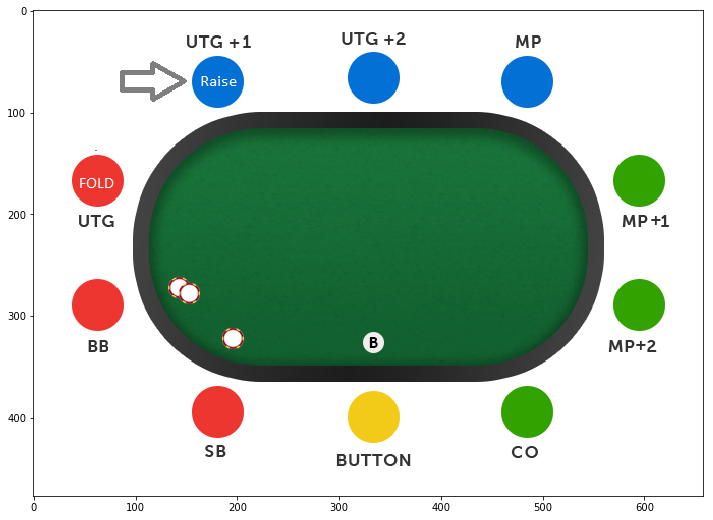

In [161]:
plt.figure(figsize=(12, 9))
img = mpimg.imread('pictures/positions_UTG_1.png')
plt.imshow(img);

In [67]:
tourney_hand_summary['UTG_1_act_p_1'] = tourney_hand_summary['UTG_1_act_p'].apply(lambda x: str(x)[:1])

In [68]:
data_UTG_1 = tourney_hand_summary[(tourney_hand_summary.UTG_act_p=='F') & (tourney_hand_summary.UTG_1_act_p_1=='R')]

In [69]:
data_UTG_1.shape

(9436, 92)

In [70]:
data_UTG_1.columns

Index(['Unnamed: 0', 'id_hand', 'id_blinds', 'id_table', 'hand_no',
       'cnt_players', 'id_table.1', 'cnt_players.1',
       'cnt_players_lookup_position', 'cnt_players_f', 'cnt_players_t',
       'cnt_players_r', 'amt_pot', 'amt_short_stack', 'amt_pot_p', 'amt_pot_f',
       'amt_pot_t', 'amt_pot_r', 'str_actors_p', 'str_actors_f',
       'str_actors_t', 'str_actors_r', 'str_aggressors_p', 'str_aggressors_f',
       'str_aggressors_t', 'str_aggressors_r', 'id_win_hand', 'id_win_hand_lo',
       'id_winner', 'id_winner_lo', 'button', 'card_1', 'card_2', 'card_3',
       'card_4', 'card_5', 'UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb', 'MP_2_bb',
       'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'UTG_card', 'UTG_1_card',
       'MP_card', 'MP_1_card', 'MP_2_card', 'CO_card', 'BUTTON_card',
       'SB_card', 'BB_card', 'UTG_act_p', 'UTG_1_act_p', 'MP_act_p',
       'MP_1_act_p', 'MP_2_act_p', 'CO_act_p', 'BUTTON_act_p', 'SB_act_p',
       'BB_act_p', 'UTG_amt_b_p', 'UTG_1_amt_b_p', 'MP_amt_b

In [71]:
data_UTG_1 = data_UTG_1[['UTG_1_card', 'UTG_1_amt_b_p', 'UTG_1_bb', 'MP_bb', 'MP_1_bb',
                         'MP_2_bb', 'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'UTG_1_amt_exp']]

In [72]:
data_UTG_1['profit'] = np.where(data_UTG_1.UTG_1_amt_exp > 0, 1, 0)
del data_UTG_1['UTG_1_amt_exp']

In [73]:
y = data_UTG_1['profit']
X = data_UTG_1.copy()
del X['profit']

In [74]:
name_stacks

['UTG_bb',
 'UTG_1_bb',
 'MP_bb',
 'MP_1_bb',
 'MP_2_bb',
 'CO_bb',
 'BUTTON_bb',
 'SB_bb',
 'BB_bb']

In [75]:
for name in name_stacks:
    if name=='SB_bb':
        pos='BB'
    elif name=='BB_bb':
        pos='SB'
    else:
        pos='other'
    try:
        X[name + '_odds'] = X[['UTG_1_amt_b_p', name]].apply(calculate_pot_odds, pos=pos, axis=1)
    except KeyError:
        continue

In [76]:
for name in name_stacks:
    for k in range(len(groups)-1):
        try:
            X[name + '_' + str(groups[k+1])] = np.where(((X[name]>=groups[k]) & (X[name] <groups[k+1])), 1, 0)
        except KeyError:
            continue  
    try:
        del X[name]
    except KeyError:
        continue  

In [77]:
del X['UTG_1_bb_odds']

#### Получим предсказания использую модель CatBoostClassifier с оптимальными параметрами.

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train, cat_features=[0])

In [79]:
preds_class = clf.predict(X_test)
print(classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.62      0.47      0.53       753
          1       0.70      0.81      0.75      1135

avg / total       0.66      0.67      0.66      1888



### UTG+1 действие если первый игрок сделал ставку.
У нас есть модель с оптимальными параметрами. Теперь перейдем к анализу других позиций.
Проанализируем позицию UTG+1, если игрок на позиции UTG выкинул карты.
Признаки:
- стеки игроков, кроме UTG, поскольку этот игрок уже не учавствует в раздаче.
- ставка игрока на позиции UTG
- пот-оддсы
- категория стека игрока

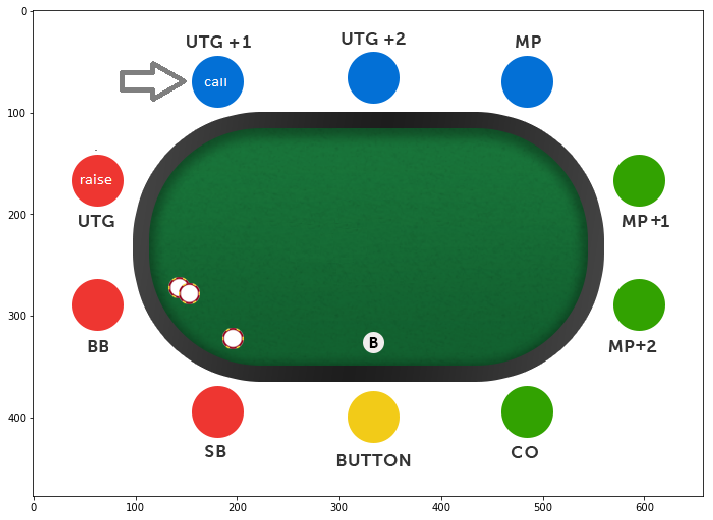

In [163]:
plt.figure(figsize=(12, 9))
img = mpimg.imread('pictures/positions_UTG_1_call.png')
plt.imshow(img);

In [80]:
data_UTG_1_after_raise = tourney_hand_summary[(tourney_hand_summary.UTG_act_p_1=='R') &
                                              (tourney_hand_summary.UTG_1_act_p_1=='C')]

In [81]:
data_UTG_1_after_raise = data_UTG_1_after_raise[['UTG_1_card', 'UTG_1_amt_b_p', 'UTG_amt_b_p', 'UTG_bb', 'UTG_1_bb', 
                                                 'MP_bb', 'MP_1_bb', 'MP_2_bb', 'CO_bb', 'BUTTON_bb',
                                                 'SB_bb', 'BB_bb', 'UTG_1_amt_exp']]

In [82]:
data_UTG_1_after_raise['profit'] = np.where(data_UTG_1_after_raise.UTG_1_amt_exp > 0, 1, 0)
del data_UTG_1_after_raise['UTG_1_amt_exp']

In [83]:
data_UTG_1_after_raise.shape

(582, 13)

In [84]:
y = data_UTG_1_after_raise['profit']
X = data_UTG_1_after_raise.copy()
del X['profit']

In [85]:
for name in name_stacks:
    for k in range(len(groups)-1):
        try:
            X[name + '_' + str(groups[k+1])] = np.where(((X[name]>=groups[k]) & (X[name] <groups[k+1])), 1, 0)
        except KeyError:
            continue  
    try:
        del X[name]
    except KeyError:
        continue  

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train, cat_features=[0])

In [87]:
preds_class = clf.predict(X_test)
print(classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.67      0.79      0.72        71
          1       0.55      0.39      0.46        46

avg / total       0.62      0.63      0.62       117



### MP raise (рейз после того, как игроки, сидящие перед MP выкинули карты в пас).
У нас есть модель с оптимальными параметрами. Теперь перейдем к анализу других позиций.
Проанализируем позицию UTG+1, если игрок на позиции UTG выкинул карты.
Признаки:
- стеки игроков, кроме UTG, UTG+1, UTG+2 так как эти игроки не учавствуют в раздаче.
- ставка игрока на позиции MP
- пот-оддсы
- категория стека игрока

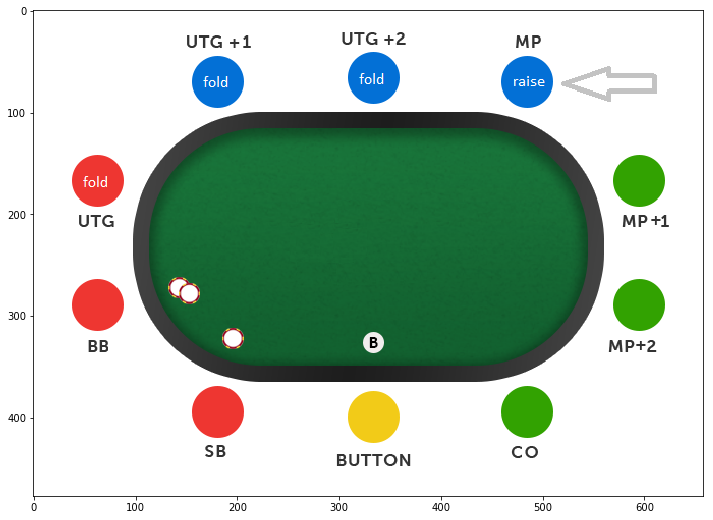

In [177]:
plt.figure(figsize=(12, 9))
img = mpimg.imread('pictures/positions_MP.png')
plt.imshow(img);

In [88]:
tourney_hand_summary['MP_act_p_1'] = tourney_hand_summary['MP_act_p'].apply(lambda x: str(x)[:1])

In [89]:
data_MP = tourney_hand_summary[(tourney_hand_summary.UTG_act_p=='F') & 
                               (tourney_hand_summary.UTG_1_act_p=='F') &
                               (tourney_hand_summary.MP_act_p_1=='R')]

In [90]:
data_MP.shape

(8697, 93)

In [91]:
data_MP.columns

Index(['Unnamed: 0', 'id_hand', 'id_blinds', 'id_table', 'hand_no',
       'cnt_players', 'id_table.1', 'cnt_players.1',
       'cnt_players_lookup_position', 'cnt_players_f', 'cnt_players_t',
       'cnt_players_r', 'amt_pot', 'amt_short_stack', 'amt_pot_p', 'amt_pot_f',
       'amt_pot_t', 'amt_pot_r', 'str_actors_p', 'str_actors_f',
       'str_actors_t', 'str_actors_r', 'str_aggressors_p', 'str_aggressors_f',
       'str_aggressors_t', 'str_aggressors_r', 'id_win_hand', 'id_win_hand_lo',
       'id_winner', 'id_winner_lo', 'button', 'card_1', 'card_2', 'card_3',
       'card_4', 'card_5', 'UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb', 'MP_2_bb',
       'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'UTG_card', 'UTG_1_card',
       'MP_card', 'MP_1_card', 'MP_2_card', 'CO_card', 'BUTTON_card',
       'SB_card', 'BB_card', 'UTG_act_p', 'UTG_1_act_p', 'MP_act_p',
       'MP_1_act_p', 'MP_2_act_p', 'CO_act_p', 'BUTTON_act_p', 'SB_act_p',
       'BB_act_p', 'UTG_amt_b_p', 'UTG_1_amt_b_p', 'MP_amt_b

In [92]:
data_MP = data_MP[['MP_card', 'MP_amt_b_p', 'MP_bb', 'MP_1_bb',
                         'MP_2_bb', 'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'MP_amt_exp']]

In [93]:
data_MP['profit'] = np.where(data_MP.MP_amt_exp > 0, 1, 0)
del data_MP['MP_amt_exp']

In [94]:
y = data_MP['profit']
X = data_MP.copy()
del X['profit']

In [95]:
for name in name_stacks:
    if name=='SB_bb':
        pos='BB'
    elif name=='BB_bb':
        pos='SB'
    else:
        pos='other'
    try:
        X[name + '_odds'] = X[['MP_amt_b_p', name]].apply(calculate_pot_odds, pos=pos, axis=1)
    except KeyError:
        continue

In [96]:
for name in name_stacks:
    for k in range(len(groups)-1):
        try:
            X[name + '_' + str(groups[k+1])] = np.where(((X[name]>=groups[k]) & (X[name] <groups[k+1])), 1, 0)
        except KeyError:
            continue  
    try:
        del X[name]
    except KeyError:
        continue  

In [97]:
del X['MP_bb_odds']

#### Получим предсказания использую модель CatBoostClassifier с оптимальными параметрами.

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train, cat_features=[0])

In [99]:
preds_class = clf.predict(X_test)
print(classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.60      0.42      0.49       688
          1       0.68      0.82      0.74      1052

avg / total       0.65      0.66      0.65      1740



### MP_1 raise (рейз после того, как игроки, сидящие перед MP_1 выкинули карты в пас).
У нас есть модель с оптимальными параметрами. Теперь перейдем к анализу других позиций.
Проанализируем позицию UTG+1, если игрок на позиции UTG выкинул карты.
Признаки:
- стеки игроков, кроме UTG, UTG+1, UTG+2, MP так как эти игроки не учавствуют в раздаче.
- ставка игрока на позиции MP_1
- пот-оддсы
- категория стека игрока

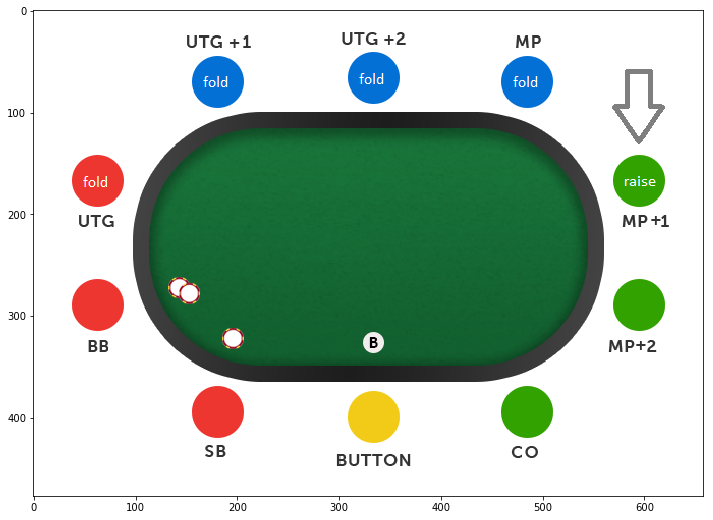

In [167]:
plt.figure(figsize=(12, 9))
img = mpimg.imread('pictures/positions_MP_1.png')
plt.imshow(img);

In [100]:
tourney_hand_summary['MP_1_act_p_1'] = tourney_hand_summary['MP_1_act_p'].apply(lambda x: str(x)[:1])

In [101]:
data_MP_1 = tourney_hand_summary[(tourney_hand_summary.UTG_act_p=='F') & 
                                 (tourney_hand_summary.UTG_1_act_p=='F') &
                                 (tourney_hand_summary.MP_act_p_1=='F') &
                                 (tourney_hand_summary.MP_1_act_p_1=='R')]

In [102]:
data_MP_1.shape

(7136, 94)

In [103]:
data_MP_1.columns

Index(['Unnamed: 0', 'id_hand', 'id_blinds', 'id_table', 'hand_no',
       'cnt_players', 'id_table.1', 'cnt_players.1',
       'cnt_players_lookup_position', 'cnt_players_f', 'cnt_players_t',
       'cnt_players_r', 'amt_pot', 'amt_short_stack', 'amt_pot_p', 'amt_pot_f',
       'amt_pot_t', 'amt_pot_r', 'str_actors_p', 'str_actors_f',
       'str_actors_t', 'str_actors_r', 'str_aggressors_p', 'str_aggressors_f',
       'str_aggressors_t', 'str_aggressors_r', 'id_win_hand', 'id_win_hand_lo',
       'id_winner', 'id_winner_lo', 'button', 'card_1', 'card_2', 'card_3',
       'card_4', 'card_5', 'UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb', 'MP_2_bb',
       'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'UTG_card', 'UTG_1_card',
       'MP_card', 'MP_1_card', 'MP_2_card', 'CO_card', 'BUTTON_card',
       'SB_card', 'BB_card', 'UTG_act_p', 'UTG_1_act_p', 'MP_act_p',
       'MP_1_act_p', 'MP_2_act_p', 'CO_act_p', 'BUTTON_act_p', 'SB_act_p',
       'BB_act_p', 'UTG_amt_b_p', 'UTG_1_amt_b_p', 'MP_amt_b

In [104]:
data_MP_1 = data_MP_1[['MP_1_card', 'MP_1_amt_b_p', 'MP_1_bb',
                         'MP_2_bb', 'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'MP_1_amt_exp']]

In [105]:
data_MP_1['profit'] = np.where(data_MP_1.MP_1_amt_exp > 0, 1, 0)
del data_MP_1['MP_1_amt_exp']

In [106]:
y = data_MP_1['profit']
X = data_MP_1.copy()
del X['profit']

In [107]:
for name in name_stacks:
    if name=='SB_bb':
        pos='BB'
    elif name=='BB_bb':
        pos='SB'
    else:
        pos='other'
    try:
        X[name + '_odds'] = X[['MP_1_amt_b_p', name]].apply(calculate_pot_odds, pos=pos, axis=1)
    except KeyError:
        continue

In [108]:
for name in name_stacks:
    for k in range(len(groups)-1):
        try:
            X[name + '_' + str(groups[k+1])] = np.where(((X[name]>=groups[k]) & (X[name] <groups[k+1])), 1, 0)
        except KeyError:
            continue  
    try:
        del X[name]
    except KeyError:
        continue  

In [109]:
del X['MP_1_bb_odds']

#### Получим предсказания использую модель CatBoostClassifier с оптимальными параметрами.

In [110]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train, cat_features=[0])

In [111]:
preds_class = clf.predict(X_test)
print(classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.69      0.38      0.49       620
          1       0.65      0.87      0.74       808

avg / total       0.67      0.66      0.63      1428



### MP_2 raise (рейз после того, как игроки, сидящие перед MP_2 выкинули карты в пас).
У нас есть модель с оптимальными параметрами. Теперь перейдем к анализу других позиций.
Проанализируем позицию UTG+1, если игрок на позиции UTG выкинул карты.
Признаки:
- стеки игроков, кроме UTG, UTG+1, UTG+2, MP, MP_1 так как эти игроки не учавствуют в раздаче.
- ставка игрока на позиции MP_2
- пот-оддсы
- категория стека игрока

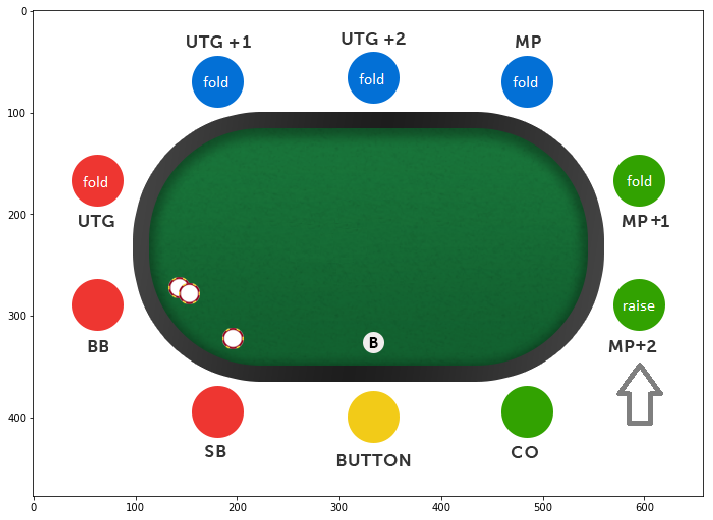

In [169]:
plt.figure(figsize=(12, 9))
img = mpimg.imread('pictures/positions_MP_2.png')
plt.imshow(img);

In [112]:
tourney_hand_summary['MP_2_act_p_1'] = tourney_hand_summary['MP_2_act_p'].apply(lambda x: str(x)[:1])

In [113]:
data_MP_2 = tourney_hand_summary[(tourney_hand_summary.UTG_act_p=='F') & 
                                 (tourney_hand_summary.UTG_1_act_p=='F') &
                                 (tourney_hand_summary.MP_act_p=='F') &
                                 (tourney_hand_summary.MP_1_act_p=='F') &
                                 (tourney_hand_summary.MP_2_act_p_1=='R')]

In [114]:
data_MP_2.shape

(4082, 95)

In [115]:
data_MP_2.columns

Index(['Unnamed: 0', 'id_hand', 'id_blinds', 'id_table', 'hand_no',
       'cnt_players', 'id_table.1', 'cnt_players.1',
       'cnt_players_lookup_position', 'cnt_players_f', 'cnt_players_t',
       'cnt_players_r', 'amt_pot', 'amt_short_stack', 'amt_pot_p', 'amt_pot_f',
       'amt_pot_t', 'amt_pot_r', 'str_actors_p', 'str_actors_f',
       'str_actors_t', 'str_actors_r', 'str_aggressors_p', 'str_aggressors_f',
       'str_aggressors_t', 'str_aggressors_r', 'id_win_hand', 'id_win_hand_lo',
       'id_winner', 'id_winner_lo', 'button', 'card_1', 'card_2', 'card_3',
       'card_4', 'card_5', 'UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb', 'MP_2_bb',
       'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'UTG_card', 'UTG_1_card',
       'MP_card', 'MP_1_card', 'MP_2_card', 'CO_card', 'BUTTON_card',
       'SB_card', 'BB_card', 'UTG_act_p', 'UTG_1_act_p', 'MP_act_p',
       'MP_1_act_p', 'MP_2_act_p', 'CO_act_p', 'BUTTON_act_p', 'SB_act_p',
       'BB_act_p', 'UTG_amt_b_p', 'UTG_1_amt_b_p', 'MP_amt_b

In [116]:
data_MP_2 = data_MP_2[['MP_2_card', 'MP_2_amt_b_p', 'MP_2_bb', 'CO_bb', 
                       'BUTTON_bb', 'SB_bb', 'BB_bb', 'MP_2_amt_exp']]

In [117]:
data_MP_2['profit'] = np.where(data_MP_2.MP_2_amt_exp > 0, 1, 0)
del data_MP_2['MP_2_amt_exp']

In [118]:
y = data_MP_2['profit']
X = data_MP_2.copy()
del X['profit']

In [119]:
for name in name_stacks:
    if name=='SB_bb':
        pos='BB'
    elif name=='BB_bb':
        pos='SB'
    else:
        pos='other'
    try:
        X[name + '_odds'] = X[['MP_2_amt_b_p', name]].apply(calculate_pot_odds, pos=pos, axis=1)
    except KeyError:
        continue

In [120]:
for name in name_stacks:
    for k in range(len(groups)-1):
        try:
            X[name + '_' + str(groups[k+1])] = np.where(((X[name]>=groups[k]) & (X[name] <groups[k+1])), 1, 0)
        except KeyError:
            continue  
    try:
        del X[name]
    except KeyError:
        continue  

In [121]:
del X['MP_2_bb_odds']

#### Получим предсказания использую модель CatBoostClassifier с оптимальными параметрами.

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train, cat_features=[0])

In [123]:
preds_class = clf.predict(X_test)
print(classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.60      0.39      0.48       327
          1       0.67      0.82      0.74       490

avg / total       0.64      0.65      0.63       817



### CO raise (рейз после того, как игроки, сидящие перед CO выкинули карты в пас).
У нас есть модель с оптимальными параметрами. Теперь перейдем к анализу других позиций.
Проанализируем позицию UTG+1, если игрок на позиции UTG выкинул карты.
Признаки:
- стеки игроков, кроме UTG, UTG+1, UTG+2, MP, MP_1, MP_2  так как эти игроки не учавствуют в раздаче.
- ставка игрока на позиции CO
- пот-оддсы
- категория стека игрока

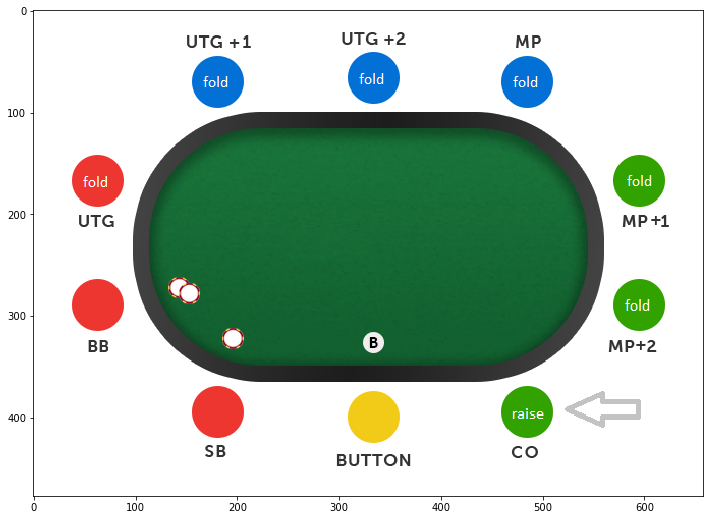

In [172]:
plt.figure(figsize=(12, 9))
img = mpimg.imread('pictures/positions_CO.png')
plt.imshow(img);

In [124]:
tourney_hand_summary['CO_act_p_1'] = tourney_hand_summary['CO_act_p'].apply(lambda x: str(x)[:1])

In [125]:
data_CO = tourney_hand_summary[(tourney_hand_summary.UTG_act_p=='F') & 
                                 (tourney_hand_summary.UTG_1_act_p=='F') &
                                 (tourney_hand_summary.MP_act_p=='F') &
                                 (tourney_hand_summary.MP_1_act_p=='F') &
                                 (tourney_hand_summary.MP_2_act_p=='F') &
                                 (tourney_hand_summary.CO_act_p_1=='R')]

In [126]:
data_CO.shape

(3660, 96)

In [127]:
data_CO.columns

Index(['Unnamed: 0', 'id_hand', 'id_blinds', 'id_table', 'hand_no',
       'cnt_players', 'id_table.1', 'cnt_players.1',
       'cnt_players_lookup_position', 'cnt_players_f', 'cnt_players_t',
       'cnt_players_r', 'amt_pot', 'amt_short_stack', 'amt_pot_p', 'amt_pot_f',
       'amt_pot_t', 'amt_pot_r', 'str_actors_p', 'str_actors_f',
       'str_actors_t', 'str_actors_r', 'str_aggressors_p', 'str_aggressors_f',
       'str_aggressors_t', 'str_aggressors_r', 'id_win_hand', 'id_win_hand_lo',
       'id_winner', 'id_winner_lo', 'button', 'card_1', 'card_2', 'card_3',
       'card_4', 'card_5', 'UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb', 'MP_2_bb',
       'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'UTG_card', 'UTG_1_card',
       'MP_card', 'MP_1_card', 'MP_2_card', 'CO_card', 'BUTTON_card',
       'SB_card', 'BB_card', 'UTG_act_p', 'UTG_1_act_p', 'MP_act_p',
       'MP_1_act_p', 'MP_2_act_p', 'CO_act_p', 'BUTTON_act_p', 'SB_act_p',
       'BB_act_p', 'UTG_amt_b_p', 'UTG_1_amt_b_p', 'MP_amt_b

In [128]:
data_CO = data_CO[['CO_card', 'CO_amt_b_p', 'CO_bb', 
                   'BUTTON_bb', 'SB_bb', 'BB_bb', 'CO_amt_exp']]

In [129]:
data_CO['profit'] = np.where(data_CO.CO_amt_exp > 0, 1, 0)
del data_CO['CO_amt_exp']

In [130]:
y = data_CO['profit']
X = data_CO.copy()
del X['profit']

In [131]:
for name in name_stacks:
    if name=='SB_bb':
        pos='BB'
    elif name=='BB_bb':
        pos='SB'
    else:
        pos='other'
    try:
        X[name + '_odds'] = X[['CO_amt_b_p', name]].apply(calculate_pot_odds, pos=pos, axis=1)
    except KeyError:
        continue

In [132]:
for name in name_stacks:
    for k in range(len(groups)-1):
        try:
            X[name + '_' + str(groups[k+1])] = np.where(((X[name]>=groups[k]) & (X[name] <groups[k+1])), 1, 0)
        except KeyError:
            continue  
    try:
        del X[name]
    except KeyError:
        continue  

In [133]:
del X['CO_bb_odds']

#### Получим предсказания использую модель CatBoostClassifier с оптимальными параметрами.

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train, cat_features=[0])

In [135]:
preds_class = clf.predict(X_test)
print(classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.56      0.25      0.35       267
          1       0.67      0.89      0.77       465

avg / total       0.63      0.65      0.61       732



### BU raise (рейз после того, как игроки, сидящие перед BU выкинули карты в пас).
У нас есть модель с оптимальными параметрами. Теперь перейдем к анализу других позиций.
Проанализируем позицию UTG+1, если игрок на позиции UTG выкинул карты.
Признаки:
- стеки игроков, кроме UTG, UTG+1, UTG+2, MP, MP_1, MP_2, CO так как эти игроки не учавствуют в раздаче.
- ставка игрока на позиции BU
- пот-оддсы
- категория стека игрока

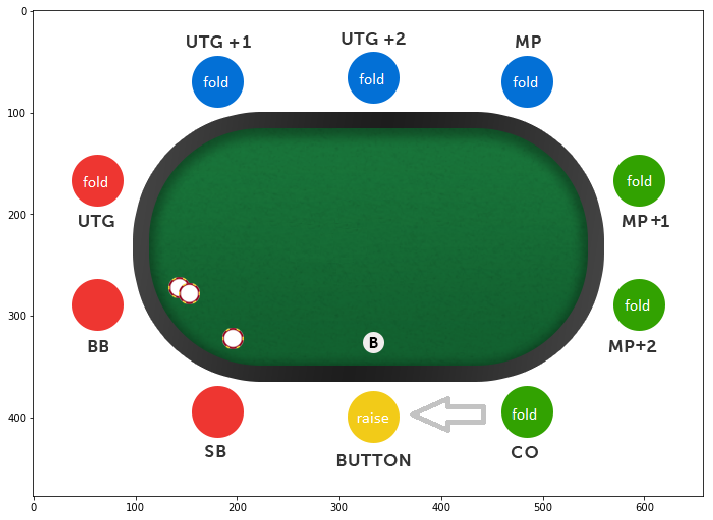

In [173]:
plt.figure(figsize=(12, 9))
img = mpimg.imread('pictures/positions_BU.png')
plt.imshow(img);

In [136]:
tourney_hand_summary['BUTTON_act_p_1'] = tourney_hand_summary['BUTTON_act_p'].apply(lambda x: str(x)[:1])

In [137]:
data_BU = tourney_hand_summary[(tourney_hand_summary.UTG_act_p=='F') & 
                                 (tourney_hand_summary.UTG_1_act_p=='F') &
                                 (tourney_hand_summary.MP_act_p=='F') &
                                 (tourney_hand_summary.MP_1_act_p=='F') &
                                 (tourney_hand_summary.MP_2_act_p=='F') &
                                 (tourney_hand_summary.CO_act_p_1=='F') &
                                 (tourney_hand_summary.BUTTON_act_p_1=='R')]

In [138]:
data_BU.shape

(3067, 97)

In [139]:
data_BU.columns

Index(['Unnamed: 0', 'id_hand', 'id_blinds', 'id_table', 'hand_no',
       'cnt_players', 'id_table.1', 'cnt_players.1',
       'cnt_players_lookup_position', 'cnt_players_f', 'cnt_players_t',
       'cnt_players_r', 'amt_pot', 'amt_short_stack', 'amt_pot_p', 'amt_pot_f',
       'amt_pot_t', 'amt_pot_r', 'str_actors_p', 'str_actors_f',
       'str_actors_t', 'str_actors_r', 'str_aggressors_p', 'str_aggressors_f',
       'str_aggressors_t', 'str_aggressors_r', 'id_win_hand', 'id_win_hand_lo',
       'id_winner', 'id_winner_lo', 'button', 'card_1', 'card_2', 'card_3',
       'card_4', 'card_5', 'UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb', 'MP_2_bb',
       'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'UTG_card', 'UTG_1_card',
       'MP_card', 'MP_1_card', 'MP_2_card', 'CO_card', 'BUTTON_card',
       'SB_card', 'BB_card', 'UTG_act_p', 'UTG_1_act_p', 'MP_act_p',
       'MP_1_act_p', 'MP_2_act_p', 'CO_act_p', 'BUTTON_act_p', 'SB_act_p',
       'BB_act_p', 'UTG_amt_b_p', 'UTG_1_amt_b_p', 'MP_amt_b

In [140]:
data_BU = data_BU[['BUTTON_card', 'BUTTON_amt_b_p', 
                   'BUTTON_bb', 'SB_bb', 'BB_bb', 'BUTTON_amt_exp']]

In [141]:
data_BU['profit'] = np.where(data_BU.BUTTON_amt_exp > 0, 1, 0)
del data_BU['BUTTON_amt_exp']

In [142]:
y = data_BU['profit']
X = data_BU.copy()
del X['profit']

In [143]:
for name in name_stacks:
    if name=='SB_bb':
        pos='BB'
    elif name=='BB_bb':
        pos='SB'
    else:
        pos='other'
    try:
        X[name + '_odds'] = X[['BUTTON_amt_b_p', name]].apply(calculate_pot_odds, pos=pos, axis=1)
    except KeyError:
        continue

In [144]:
for name in name_stacks:
    for k in range(len(groups)-1):
        try:
            X[name + '_' + str(groups[k+1])] = np.where(((X[name]>=groups[k]) & (X[name] <groups[k+1])), 1, 0)
        except KeyError:
            continue  
    try:
        del X[name]
    except KeyError:
        continue  

In [145]:
del X['BUTTON_bb_odds']

#### Получим предсказания использую модель CatBoostClassifier с оптимальными параметрами.

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train, cat_features=[0])

In [147]:
preds_class = clf.predict(X_test)
print(classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.62      0.20      0.30       240
          1       0.64      0.92      0.76       374

avg / total       0.63      0.64      0.58       614



### SB raise (рейз после того, как игроки, сидящие перед SB выкинули карты в пас).
У нас есть модель с оптимальными параметрами. Теперь перейдем к анализу других позиций.
Проанализируем позицию UTG+1, если игрок на позиции UTG выкинул карты.
Признаки:
- стеки игроков, кроме UTG, UTG+1, UTG+2, MP, MP_1, MP_2, CO, BU так как эти игроки не учавствуют в раздаче.
- ставка игрока на позиции SB
- пот-оддсы
- категория стека игрока

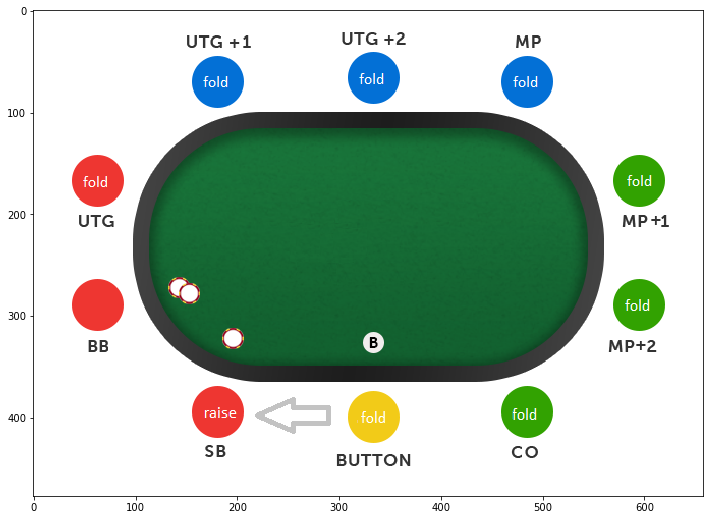

In [175]:
plt.figure(figsize=(12, 9))
img = mpimg.imread('pictures/positions_SB.png')
plt.imshow(img);

In [148]:
tourney_hand_summary['SB_act_p_1'] = tourney_hand_summary['SB_act_p'].apply(lambda x: str(x)[:1])

In [149]:
data_SB = tourney_hand_summary[(tourney_hand_summary.UTG_act_p=='F') & 
                                 (tourney_hand_summary.UTG_1_act_p=='F') &
                                 (tourney_hand_summary.MP_act_p=='F') &
                                 (tourney_hand_summary.MP_1_act_p=='F') &
                                 (tourney_hand_summary.MP_2_act_p=='F') &
                                 (tourney_hand_summary.CO_act_p=='F') &
                                 (tourney_hand_summary.BUTTON_act_p=='F') &
                                 (tourney_hand_summary.SB_act_p_1=='R')]

In [150]:
data_SB.shape

(1955, 98)

In [151]:
data_SB.columns

Index(['Unnamed: 0', 'id_hand', 'id_blinds', 'id_table', 'hand_no',
       'cnt_players', 'id_table.1', 'cnt_players.1',
       'cnt_players_lookup_position', 'cnt_players_f', 'cnt_players_t',
       'cnt_players_r', 'amt_pot', 'amt_short_stack', 'amt_pot_p', 'amt_pot_f',
       'amt_pot_t', 'amt_pot_r', 'str_actors_p', 'str_actors_f',
       'str_actors_t', 'str_actors_r', 'str_aggressors_p', 'str_aggressors_f',
       'str_aggressors_t', 'str_aggressors_r', 'id_win_hand', 'id_win_hand_lo',
       'id_winner', 'id_winner_lo', 'button', 'card_1', 'card_2', 'card_3',
       'card_4', 'card_5', 'UTG_bb', 'UTG_1_bb', 'MP_bb', 'MP_1_bb', 'MP_2_bb',
       'CO_bb', 'BUTTON_bb', 'SB_bb', 'BB_bb', 'UTG_card', 'UTG_1_card',
       'MP_card', 'MP_1_card', 'MP_2_card', 'CO_card', 'BUTTON_card',
       'SB_card', 'BB_card', 'UTG_act_p', 'UTG_1_act_p', 'MP_act_p',
       'MP_1_act_p', 'MP_2_act_p', 'CO_act_p', 'BUTTON_act_p', 'SB_act_p',
       'BB_act_p', 'UTG_amt_b_p', 'UTG_1_amt_b_p', 'MP_amt_b

In [152]:
data_SB = data_SB[['SB_card', 'SB_amt_b_p', 
                   'SB_bb', 'BB_bb', 'SB_amt_exp']]

In [153]:
data_SB['profit'] = np.where(data_SB.SB_amt_exp > -0.5, 1, 0)
del data_SB['SB_amt_exp']

In [154]:
y = data_SB['profit']
X = data_SB.copy()
del X['profit']

In [155]:
for name in name_stacks:
    if name=='SB_bb':
        pos='BB'
    elif name=='BB_bb':
        pos='SB'
    else:
        pos='other'
    try:
        X[name + '_odds'] = X[['SB_amt_b_p', name]].apply(calculate_pot_odds, pos=pos, axis=1)
    except KeyError:
        continue

In [156]:
for name in name_stacks:
    for k in range(len(groups)-1):
        try:
            X[name + '_' + str(groups[k+1])] = np.where(((X[name]>=groups[k]) & (X[name] <groups[k+1])), 1, 0)
        except KeyError:
            continue  
    try:
        del X[name]
    except KeyError:
        continue  

In [157]:
del X['SB_bb_odds']

#### Получим предсказания использую модель CatBoostClassifier с оптимальными параметрами

In [158]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
clf.fit(X_train, y_train, cat_features=[0])

In [159]:
preds_class = clf.predict(X_test)
print(classification_report(y_test, preds_class))

             precision    recall  f1-score   support

          0       0.62      0.32      0.42       100
          1       0.80      0.93      0.86       291

avg / total       0.75      0.77      0.75       391



# Заключение.

Был проанализирован рейз на префлопе в покере. Ответ 1 - означал, что рейз принесет положительную прибыль, 0 - отрицательную, следовательно, если наша модель предсказала класс 0, следовательно в данной ситуции фолд(выбросить карты в пас) предпочтительней.

Дальнешая работа:
Добавить признаков, например, тип турнира, стоиомость турнира, статистику по оппонентам.
Проанализировать другие ситуации: кол на префлопе, ререйз, также рассмотреть действия на других улицах (флоп, терн, ривер).